##### This notebook creates a coauthorship network and identifies communities within it. It also analyses the important keywords and terms associated with each community/ cluster

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import re

In [2]:
pickleStoragePath   = "/Users/srai1029/Documents/projects/david_nyu/data/peds_spine_clean_sumedha.pkl"
# Unpickle as a pickled pandas Series object

data = pd.read_pickle(pickleStoragePath)
# remove all columns where there are no keywords recorded
data_nona = data[data.authors_keywords.notna()]
print(f'length of dataset after removing nas from keywords column {len(data_nona)}')
# look at the dataset
data_nona.head(2)

length of dataset after removing nas from keywords column 10908


,title,abstract,pub_year,cited_references,authors_keywords,wos_keywords_plus,authors,authors_full_names,gender_list,race_list,affiliations_list,countries
0,INTRACRANIAL CAVERNOUS ANGIOMA IN THE 1ST YEAR...,THREE CASES OF SYMPTOMATIC CAVERNOUS ANGIOMA O...,1992,"[CHADDUCK WM, 1985, NEUROSURGERY, V16, P189, D...",CAVERNOUS ANGIOMA; SURGERY; LITERATURE REVIEW,HEMANGIOMA; MALFORMATIONS; DIAGNOSIS; CHILDREN...,SAKAI N;YAMADA H;NISHIMURA Y;SHIRAKAMI S;FUTAM...,"[Noboru Sakai, Hiromu Yamada, Yasuaki Nishimur...","[male, male, male, male, male, male]","[Asian, Asian, Asian, Asian, Asian, Asian]",NaN,[JAPAN]
1,SPONTANEOUS SPINAL EXTRADURAL HEMATOMA IN CHIL...,THREE YOUNG CHILDREN WHO PRESENTED WITH ACUTE ...,1992,"[BRAWN LA, 1986, POSTGRAD MED J, V62, P885, DO...",SPONTANEOUS SPINAL EXTRADURAL HEMATOMA; SPINAL...,EPIDURAL HEMATOMA; PARAPLEGIA; RECOVERY,TEWARI MK;TRIPATHI LN;MATHURIYA SN;KHANDELWAL ...,"[Manoj Tewari, L. Tripathi, Suresh Mathuriya, ...","[male, male, male, male, male]","[Asian, Asian, Asian, Asian, Asian]",[POST GRADUATE INSTITUTE OF MEDICAL EDUCATION ...,"[INDIA, INDIA]"


In [3]:
# create a separate df for constructing the network graph with relevant keywords
graph_df = data_nona[['authors', 'authors_keywords', 'countries', 'pub_year']]

# clean the authors column to make the column into a list of names
graph_df['authors'] = graph_df['authors'].apply(lambda row: row.split(';'))

# clean the keywords column for use later (convert to a list of string values)
graph_df['authors_keywords'] = graph_df['authors_keywords'].apply(lambda row: re.sub(';', '', row))
graph_df['authors_keywords'] = graph_df['authors_keywords'].apply(lambda row: [str(word) for word in row.split()])

# look at the dataset
graph_df

,authors,authors_keywords,countries,pub_year
0,"[SAKAI N, YAMADA H, NISHIMURA Y, SHIRAKAMI S, ...","[CAVERNOUS, ANGIOMA, SURGERY, LITERATURE, REVIEW]",[JAPAN],1992
1,"[TEWARI MK, TRIPATHI LN, MATHURIYA SN, KHANDEL...","[SPONTANEOUS, SPINAL, EXTRADURAL, HEMATOMA, SP...","[INDIA, INDIA]",1992
2,"[MIGLIORE A, CALZOLARI F, MARZOLA A, GHADIRPOU...","[PEDIATRIC, CRANIOPHARYNGIOMA, III-VENTRICLE, ...","[ITALY, ITALY, ITALY]",1992
3,"[SCHWEITZER JS, BATZDORF U]","[CAUDA, EQUINA, EPENDYMOMA, MAGNETIC, RESONANC...",[],1992
5,"[KAHMANN RD, DONOHUE JM, BRADFORD DS, WHITE JG...","[IDIOPATHIC, SCOLIOSIS, AGGREGATION, DENSE, BO...",[],1992
...,...,...,...,...
11468,"[DAS S, STONE L, GODZIK J, KELLY M]","[CHIARI, MALFORMATION, SYRINGOMYELIA, SCOLIOSI...","[USA, USA, USA, USA]",2023
11469,"[CHOTAI S, AUM DJ, STRAHLE JM]","[CHIARI, MALFORMATION, SCOLIOSIS, SYRINGOMYELI...","[USA, USA, USA, USA]",2023
11476,"[KANG JK, LEE KS, LEE IW, JEUN SS, SON BC, JUN...","[ARACHNOID, CYST, MIDDLE, CRANIAL, FOSSA, FENE...","[KOREA, KOREA]",2000
11482,"[O'TOOLE JE, CONNOLLY ES, KHANDJI AG, FELDSTEI...","[CERVICAL, SPINE, CHONDROSARCOMA, CORD, COMPRE...","[USA, USA, USA, USA, USA, USA]",2004


In [4]:
# list of authors with their original names (initials and last names) - this is used for labeling the graph later
authors_orig = \
[
'LENKE LG','BRIDWELL KH','NEWTON PO','LABELLE H','BETZ RR','AUBIN CE','SHAH SA','CHENG JCY','DI ROCCO C','SAMDANI AF','QIU Y',
'SPONSELLER PD','JALLO GI','KIM YJ','STEINBOK P','DORMANS JP','MENEZES AH','PARENT S','SUCATO DJ','WANG KC','LONNER BS',
'ANDERSON RCE','JEA A','HWANG SW','BROCKMEYER DL','PAHYS JM','TAKAHASHI J','WATANABE K'
]
len(authors_orig)

28

In [5]:
# list of authors with their original names (initials and last names)
full_names = \
['Lawrence Lenke','Keith Bridwell','Peter Newton','Hubert Labelle','Randal Betz','Carl-Eric Aubin','Suken Shah','Jack Cheng',
'C. Di Rocco','Amer Samdani','Yong Qiu','Paul Sponseller','George Jallo','Yongjung Kim','Paul Steinbok','John Dormans','Arnold Menezes',
'Stefan Parent','Daniel Sucato','Kyu-Chang Wang','Baron Lonner','Richard Anderson','Andrew Jea','Steven Hwang',
'Douglas Brockmeyer','Joshua Pahys','Jun Takahashi','Kota Watanabe'
]
len(full_names)

28

In [6]:
# keep both the name format in a dictionary so I can interchange them whenever needed
author_names_dict = dict(zip(authors_orig, full_names))
# author_names_dict


In [7]:
# this creates an author_publications_dict with all author original names as keys and their publication counts as values
author_publications_dict = {}

for index, row in graph_df['authors'].items():
    for name in row:
        if name in author_publications_dict:
            author_publications_dict[name] += 1
        else:
            author_publications_dict[name] = 1

In [8]:
# print(len(author_publications_dict)) # without dropping authors - 31243 unique authors

# filter dict with values >=15 - get all the authors that have a publication count of 15 or more
author_filtered = {key: value for key, value in author_publications_dict.items() if value >= 15}

# get a list of all the authors to be included
authors_filtered_list = list(author_filtered.keys())
len(authors_filtered_list)

322

In [9]:
# this function is used to create a column in graph df that only includes authors with 15 publication or more
def filter_names(original_list):
    return [element for element in original_list if element in authors_filtered_list]

In [10]:
graph_df['authors_filtered'] = graph_df['authors'].apply(filter_names)
graph_df.head(5)

,authors,authors_keywords,countries,pub_year,authors_filtered
0,"[SAKAI N, YAMADA H, NISHIMURA Y, SHIRAKAMI S, ...","[CAVERNOUS, ANGIOMA, SURGERY, LITERATURE, REVIEW]",[JAPAN],1992,[]
1,"[TEWARI MK, TRIPATHI LN, MATHURIYA SN, KHANDEL...","[SPONTANEOUS, SPINAL, EXTRADURAL, HEMATOMA, SP...","[INDIA, INDIA]",1992,[]
2,"[MIGLIORE A, CALZOLARI F, MARZOLA A, GHADIRPOU...","[PEDIATRIC, CRANIOPHARYNGIOMA, III-VENTRICLE, ...","[ITALY, ITALY, ITALY]",1992,[]
3,"[SCHWEITZER JS, BATZDORF U]","[CAUDA, EQUINA, EPENDYMOMA, MAGNETIC, RESONANC...",[],1992,[]
5,"[KAHMANN RD, DONOHUE JM, BRADFORD DS, WHITE JG...","[IDIOPATHIC, SCOLIOSIS, AGGREGATION, DENSE, BO...",[],1992,[]


In [11]:
# choose only those rows as 'chosen authors' have authors in the authors_filtered column and not empty lists
chosen_authors = graph_df[graph_df['authors_filtered'].apply(lambda x: len(x) > 0)]
chosen_authors.head(5)

,authors,authors_keywords,countries,pub_year,authors_filtered
12,"[RUGE JR, MASCIOPINTO J, STORRS BB, MCLONE DG]","[CHIARI-II, MENINGOMYELOCELE, POSTERIOR, FOSSA...",[USA],1992,[MCLONE DG]
13,"[STEINBOK P, IRVINE B, COCHRANE DD, IRWIN BJ]","[MENINGOMYELOCELE, AMBULATION, SCHOOL, PERFORM...","[CANADA, CANADA]",1992,"[STEINBOK P, COCHRANE DD]"
18,"[LENKE LG, BRIDWELL KH, BALDUS C, BLANKE K]","[PULMONARY, FUNCTION, TESTING, APICAL, ROTATIO...",[],1992,"[LENKE LG, BRIDWELL KH]"
19,"[JOHNSON DL, DUMA C, SIVIT C, MCCOMB JG]","[BURR, HOLES, COMA, SCORE, COMPUTED, TOMOGRAPH...",[],1992,[MCCOMB JG]
20,"[OSENBACH RK, MENEZES AH, REKATE HL]","[PEDIATRIC, SPINE, SPINAL, CORD, INJURY, SPINA...",[],1992,"[MENEZES AH, REKATE HL]"


In [12]:
# create combination links of authors and coauthors
def combinations2(author_list):

    list_combs = list(combinations(author_list, 2))
    df = pd.DataFrame(list_combs, columns=['author', 'co_author'])

    return df

In [13]:
# create a master_df that only shows the combinations. This will create a df that will only be used for the graph
master_df = pd.DataFrame()
from itertools import combinations

for index, row in chosen_authors['authors_filtered'].items():

    # convert row to a list and then take the first element (that's the actual list) - then send to function
    df = combinations2(row) 
    master_df = pd.concat([master_df, df])

master_df.reset_index(inplace=True)
master_df = master_df.drop('index', axis=1)

In [14]:
# sort the rows in such as way that (a,b) and (b,a) become (a,b) and (a,b). This will help drop duplicates
master_df[['author', 'co_author']] = np.sort(master_df[['author', 'co_author']], axis=1)
master_df_unique = master_df.drop_duplicates()
master_df_unique.head(10)

,author,co_author
0,COCHRANE DD,STEINBOK P
1,BRIDWELL KH,LENKE LG
2,MENEZES AH,REKATE HL
3,LASJAUNIAS P,ZERAH M
4,MENEZES AH,WEINSTEIN SL
6,HOFFMAN HJ,REKATE HL
8,DRAKE JM,HOFFMAN HJ
9,HOFFMAN HJ,MENEZES AH
11,HOFFMAN HJ,MCLONE DG
13,LABELLE H,POITRAS B


In [15]:
# get the number of publications associated with each author - this is for creating size of nodes in the graph

# count each author's name occurrence, that gives us the number of publications associated with the author
listOfall_authors = [*graph_df.authors]
list_authors = [x for sublist in listOfall_authors for x in sublist]
# print(list_authors)
from collections import Counter
pubs_count_dict = dict(Counter(list_authors))
sorted_pubs_count = sorted(pubs_count_dict.items(), key=lambda item: item[1], reverse=True)
sorted_pubs_count

pubs50 = [key for key, value in pubs_count_dict.items() if value>=50]
pubs40_50 = [key for key, value in pubs_count_dict.items() if (value<50) & (value>=40)]
pubs30_40 = [key for key, value in pubs_count_dict.items() if (value<40) & (value>=30)]
pubs20_30 = [key for key, value in pubs_count_dict.items() if (value<30) & (value>=20)]
pubs10_20 = [key for key, value in pubs_count_dict.items() if (value<20) & (value>=10)]
pubs1_10 = [key for key, value in pubs_count_dict.items() if (value<10) & (value>=1)]

Create the graph

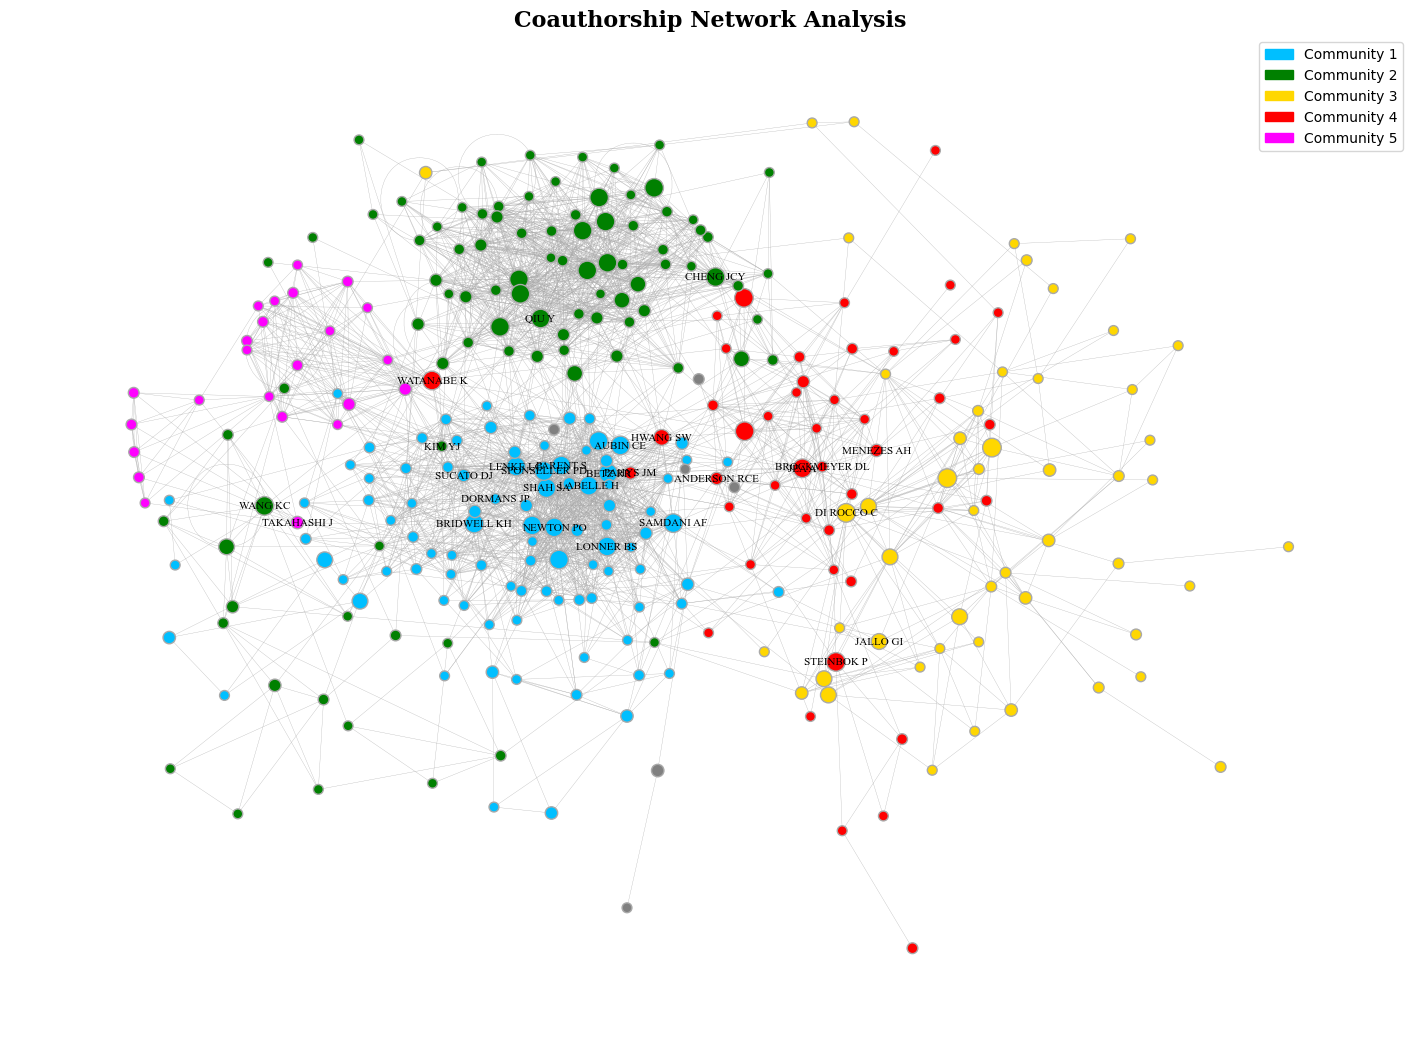

In [16]:

import community
from networkx.algorithms.community import greedy_modularity_communities
from matplotlib.patches import Patch

# create a graph instance
G = nx.Graph()
plt.figure(figsize=(14, 10))

# create a list of nodes and edges
nodes = [*master_df_unique.author, *master_df_unique.co_author] #this just gives a list of all the author names that should be used as nodes
edges = master_df_unique.values.tolist() # this gives tuple pairs of authors and coauthors to be used as edges

# add the data
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# 1. LAYOUT
# position of nodes
pos = nx.kamada_kawai_layout(G)

# 2. COMMUNITIES
# Detect communities using the greedy_modularity_communities
communities = list(greedy_modularity_communities(G))
sorted_communities = sorted(communities, key=len, reverse=True)

# 3. NODE SIZES
node_sizes = [50+10 if node in pubs20_30 
                      else 70+10 if node in pubs30_40
                      else 100+30 if node in pubs40_50 
                      else 150+30 if node in pubs50 
                      else 40+10 for node in G.nodes()]

# 4. COLORS
# Use the first 6 communities to define colors, you may want to redefine the 'colors' list or how it's used
# colors = plt.cm.RdBu_r(np.linspace(0, 1, len(sorted_communities)))
colors = ['lightskyblue', 'lightgreen', 'gold', 'orange', 'coral', 'grey']

colors = ['deepskyblue', 'green', 'gold', 'red', 'magenta', 'grey']

# color only the first 6 communities
node_colors = {}
for idx, community in enumerate(sorted_communities[:6]):
    for node in community:
        node_colors[node] = colors[idx]

# color the remaining communities/ nodes grey
# For nodes not in the first six communities, assign grey
for node in G.nodes():
    if node not in node_colors:
        node_colors[node] = colors[-1]

# convert the node_colors dictionary to a an ordered list of colors taking node values into account
node_colors_list = [node_colors[node] for node in G.nodes()]


# 5. NODE LABELS
nodes_to_label = list(author_names_dict.keys())

labels = {}
for node in nodes_to_label:
    if node in G:
        labels[node] = node 


# 6. OTHER OPTIONS
options = { 'width': 0.2, # line width of edges
          'edge_color':'darkgrey',# edge color
          'edgecolors': 'darkgrey'
        }


# 7. DRAW THE GRAPH 
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_colors_list, **options)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_family='Times New Roman')

# 8. ATTACH A LEGEND
# Create a legend using the colors
legend_labels = [Patch(color=colors[i], label=f"Community {i+1}") for i in range(0, 5)]
plt.legend(handles=legend_labels)

# 9. TITLE
font_properties = {'family': 'serif', 'weight': 'bold', 'size': 16}
plt.title('Coauthorship Network Analysis', fontdict = font_properties)

plt.savefig("greedy_modularities_final.svg", format="svg")


plt.show()

In [17]:
# get keywords for each of the communities
terms_needed = 20


label_dict = {}
label_dict['community'] = []
label_dict['community_size'] = []
label_dict['topterms'] = []
label_dict['topterms_kwards'] = []
label_dict['topauthors'] = []
label_dict['topauthors_names'] = []

for i in range(0, len(communities)):

    community_authors_list = list(communities[i])
    # print(community_authors)

    # make a subdataframe that only has authors from this community
    sub_comm_authors_df = chosen_authors[chosen_authors['authors'].apply(lambda row: any(item in community_authors_list for item in row))]

     # take the list of keywords column from this df of authors in a particular commmunity
    kwords_lst = [*sub_comm_authors_df.authors_keywords]
    kwords_lst_flat = [x for sublist in kwords_lst for x in sublist]
    kwords_count = dict(Counter(kwords_lst_flat))
    kwords_sorted = {k:v for k, v in sorted(kwords_count.items(), key=lambda item: item[1], reverse=True)}
    kwords_tuples = list(tuple(kwords_sorted.items()))
    # pick out the top x terms with frequencies
    topterms = kwords_tuples[:terms_needed]
    # pick out the words only
    topterms_kwords = [term[0] for term in topterms]

    # use the author_publications_dict to extract the authors of the community with their publication counts
    comm_authors_publications_dict = {k:v for k,v in author_publications_dict.items() if k in community_authors_list}
    # sort this by publications count
    comm_authors_publications_dict = {k:v for k, v in sorted(comm_authors_publications_dict.items(), key=lambda item: item[1], reverse=True)}
    # convert to tuples
    pubs_tuples = list(tuple(comm_authors_publications_dict.items()))
    # pick out the top x authors with publication frequencies
    topauthors = pubs_tuples[:terms_needed]
    # pick out the words only
    topauthors_names = [term[0] for term in topauthors]


    label_dict['community'].append(i+1)
    label_dict['community_size'].append(len(community_authors_list))
    label_dict['topterms'].append(topterms)
    label_dict['topterms_kwards'].append(topterms_kwords)
    label_dict['topauthors'].append(topauthors)
    label_dict['topauthors_names'].append(topauthors_names)



In [18]:
# convert label_dict to dataframe
labels_df = pd.DataFrame(label_dict)
labels_df.to_csv('greedy_modularity_final_kwords.csv')
labels_df

,community,community_size,topterms,topterms_kwards,topauthors,topauthors_names
0,1,97,"[(SCOLIOSIS, 1110), (IDIOPATHIC, 608), (ADOLES...","[SCOLIOSIS, IDIOPATHIC, ADOLESCENT, SPINAL, FU...","[(NEWTON PO, 143), (LENKE LG, 134), (LABELLE H...","[NEWTON PO, LENKE LG, LABELLE H, BETZ RR, SHAH..."
1,2,94,"[(SCOLIOSIS, 660), (IDIOPATHIC, 400), (ADOLESC...","[SCOLIOSIS, IDIOPATHIC, ADOLESCENT, SPINAL, FU...","[(QIU Y, 153), (ZHU Z, 121), (WANG Y, 84), (LI...","[QIU Y, ZHU Z, WANG Y, LIU Z, CHENG JCY, XU L,..."
2,3,51,"[(PEDIATRIC, 168), (HYDROCEPHALUS, 162), (BRAI...","[PEDIATRIC, HYDROCEPHALUS, BRAIN, SPINAL, TUMO...","[(DI ROCCO C, 67), (CONSTANTINI S, 62), (KUMAR...","[DI ROCCO C, CONSTANTINI S, KUMAR R, VINCHON M..."
3,4,45,"[(PEDIATRIC, 219), (SPINAL, 206), (SPINE, 202)...","[PEDIATRIC, SPINAL, SPINE, CORD, SCOLIOSIS, MA...","[(TUBBS RS, 90), (JEA A, 83), (STEINBOK P, 62)...","[TUBBS RS, JEA A, STEINBOK P, WATANABE K, OAKE..."
4,5,24,"[(SCOLIOSIS, 164), (IDIOPATHIC, 115), (ADOLESC...","[SCOLIOSIS, IDIOPATHIC, ADOLESCENT, SPINAL, FU...","[(TAKAHASHI J, 36), (MATSUMOTO M, 32), (KAWAKA...","[TAKAHASHI J, MATSUMOTO M, KAWAKAMI N, OBA H, ..."
5,6,2,"[(KYPHOSIS, 9), (SCOLIOSIS, 9), (SPINE, 8), (S...","[KYPHOSIS, SCOLIOSIS, SPINE, SPINAL, CERVICAL,...","[(SHETTY AP, 21), (RAJASEKARAN S, 20)]","[SHETTY AP, RAJASEKARAN S]"
6,7,2,"[(SPONDYLOLYSIS, 18), (SPINE, 18), (LUMBAR, 16...","[SPONDYLOLYSIS, SPINE, LUMBAR, SPONDYLOLISTHES...","[(SAIRYO K, 26), (SAKAI T, 16)]","[SAIRYO K, SAKAI T]"
7,8,2,"[(SPINAL, 17), (HYDROCEPHALUS, 16), (TUMORS, 1...","[SPINAL, HYDROCEPHALUS, TUMORS, CYST, OF, SPIN...","[(MARTINEZ-LAGE JF, 37), (POZA M, 15)]","[MARTINEZ-LAGE JF, POZA M]"
